In [1]:
import os
os.chdir('..')

import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from archs.mnist.AlexNet import AlexNet

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

To generate the model used in this example, I ran:

`python main.py --arch_type alexnet --dataset mnist --prune_percent 95 --prune_iterations 2 --end_iter 30`

In [2]:
# Global-like variable definitions.
model_name = 'alexnet'
dataset_name = 'mnist'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
msk_pct = 95 # prune percentage for LT network
model_loc0 = 'saves/{}/{}/0_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, un-pruned model 
model_loc1 = 'saves/{}/{}/1_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, pruned model (after 1 prune iteration)

## Unpruned Model Homology

In [3]:
# load the model.
model = torch.load(model_loc0)

In [4]:
alnt = AlexNet()

# access model params and add to list `params`. We are ignoring bias weights for now.
params = []
for name, param in model.named_parameters():
    if 'weight' in name:
        pnum = param.data.cpu().numpy()
        print('Parameter Shape: ', pnum.shape)
        params.append(pnum)

# add weights to conv and linear layer param info dict
param_info = alnt.param_info
j = 0
for i in range(len(param_info)):
    p = param_info[i]
    if p['layer_type'] == 'Conv2d' or p['layer_type'] == 'Linear':
        p['param'] = params[j]
        j += 1
    else:
        p['param'] = None

Parameter Shape:  (64, 1, 3, 3)
Parameter Shape:  (192, 64, 5, 5)
Parameter Shape:  (384, 192, 3, 3)
Parameter Shape:  (256, 384, 3, 3)
Parameter Shape:  (256, 256, 3, 3)
Parameter Shape:  (4096, 256)
Parameter Shape:  (4096, 4096)
Parameter Shape:  (10, 4096)


In [6]:
# expected size of input layer
input_size = (1,1,28,28)

In [20]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
#     assert (H + 2 * padding - field_height) % stride == 0
#     assert (W + 2 * padding - field_height) % stride == 0
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k.astype(int), i.astype(int), j.astype(int))

def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols

def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                   stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

def conv_layer_as_matrix(X, X_names, W, stride, padding):
    n_filters, d_filter, h_filter, w_filter = W.shape
    n_x, d_x, h_x, w_x = X.shape
    h_out = (h_x - h_filter + 2 * padding) / stride + 1
    w_out = (w_x - w_filter + 2 * padding) / stride + 1
    
    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    X_names_col = im2col_indices(X_names, h_filter, w_filter, padding=padding, stride=stride)
    W_col = W.reshape(n_filters, -1)
    
    out = W_col @ X_col
    out = out.reshape(n_filters, int(h_out), int(w_out), n_x)
    out = out.transpose(3, 0, 1, 2)
    
    return out, X_col, W_col, X_names_col

def inverse_abs(x):
    return np.abs(1/x)

def add_conv(G, input_size, p, name_this, name_next, stride, padding, weight_func=inverse_abs, next_linear=False):
    '''adds convolutional layer to graph and returns updated graph'''
    conv_format = '{}_{}_{}'
    input_channels = p.shape[1]
    X = np.ones(input_size)
    for c in range(input_channels):
        print('Channel: {}'.format(c))
        X_names = np.arange(X.shape[2]*X.shape[3]).reshape((1,1,X.shape[2],X.shape[3]))
        tx = X[:,c,:,:].reshape((X.shape[0],1,X.shape[2],X.shape[3]))
        # convert to matrix information
        mat, X_col, W_col, xnames = conv_layer_as_matrix(tx,X_names,p[:,c,:,:].reshape((p.shape[0],1,p.shape[2],p.shape[3])),stride,padding)
        for f in range(W_col.shape[0]):
            for row in range(X_col.shape[0]):
                for col in range(X_col.shape[1]):
                    v = W_col[f,row]
                    if v != 0:
                        if next_linear:
                            # next layer is linear
                            G.add_edge(conv_format.format(name_this,c,xnames[row,col]),conv_format.format(name_next,0,int((X_col.shape[1]*c) + (f*X_col.shape[1]) + col)), weight=weight_func(v))
                        else:
                            # next layer is conv
                            G.add_edge(conv_format.format(name_this,c,xnames[row,col]),conv_format.format(name_next,f,col), weight=weight_func(v))
    input_size = mat.shape
    return G, input_size

def add_mp(G, input_size, name_this, name_next, kernel_size, stride, padding, next_linear=False):
    '''adds max pooling layer to graph and returns updated graph'''
    conv_format = '{}_{}_{}'
    p = np.ones((input_size[0],input_size[1],kernel_size[0],kernel_size[1]))
    input_channels = p.shape[1]
    # next layer also conv
    X = np.ones(input_size)
    for c in range(input_channels):
        print('Channel: {}'.format(c))
        X_names = np.arange(X.shape[2]*X.shape[3]).reshape((1,1,X.shape[2],X.shape[3]))
        tx = X[:,c,:,:].reshape((X.shape[0],1,X.shape[2],X.shape[3]))
        # convert to matrix information
        mat, X_col, W_col, xnames = conv_layer_as_matrix(tx,X_names,p[:,c,:,:].reshape((p.shape[0],1,p.shape[2],p.shape[3])),stride,padding)
        for f in range(W_col.shape[0]):
            for row in range(X_col.shape[0]):
                for col in range(X_col.shape[1]):
                    node_name = conv_format.format(name_this,c,xnames[row,col])
                    ews = sorted(G.in_edges(node_name, data=True), key=lambda x: x[2]['weight'])
                    if len(ews) > 0:
                        v = ews[0][2]['weight']
                        if v != 0:
                            if next_linear:
                                G.add_edge(conv_format.format(name_this,c,xnames[row,col]),conv_format.format(name_next,0,int((X_col.shape[1]*c) + (f*X_col.shape[1]) + col)), weight=v)
                            else:
                                G.add_edge(conv_format.format(name_this,c,xnames[row,col]),conv_format.format(name_next,f,col), weight=v)
    input_size = [mat.shape[0], input_channels, mat.shape[2], mat.shape[3]]
    return G, input_size

def add_linear_linear(G, p, name_this, name_next, weight_func=inverse_abs):
    '''adds linear layer to graph and returns updated graph'''
    conv_format = '{}_{}_{}'
    for row in range(p.shape[1]):
        for col in range(p.shape[0]):
            v = p[col,row]
            if v != 0:
                G.add_edge(conv_format.format(name_this,0,row),conv_format.format(name_next,0,col), weight=weight_func(v))
    return G

def to_directed_networkx(params, input_size):
    # store all network info here
    G = nx.DiGraph()
    
    # assume last layer linear 
    for l in range(len(params)-1):
                
        param = params[l]
        # need to look ahead at next layer to get naming correct
        param_next = params[l+1]
        
        print('Layer: {}'.format(param['name']))
        
        if param['layer_type'] == 'Conv2d':
            
            if param_next['layer_type'] == 'Conv2d' or param_next['layer_type'] == 'MaxPool2d':
                                
                G, input_size = add_conv(G, input_size, param['param'], param['name'], param_next['name'], param['stride'], param['padding'], next_linear=False)
                
            elif param_next['layer_type'] == 'Linear':
                
                G, input_size = add_conv(G, input_size, param['param'], param['name'], param_next['name'], param['stride'], param['padding'], next_linear=True)
                
        elif param['layer_type'] == 'MaxPool2d':
            
            if param_next['layer_type'] == 'Conv2d':
                
                G, input_size = add_mp(G, input_size, param['name'], param_next['name'], param['kernel_size'], param['stride'], param['padding'], next_linear=False)
                
            if param_next['layer_type'] == 'Linear':
                
                G, input_size = add_mp(G, input_size, param['name'], param_next['name'], param['kernel_size'], param['stride'], param['padding'], next_linear=True)
                
        elif param['layer_type'] == 'Linear':
            # linear layer
            G = add_linear_linear(G, param['param'], param['name'], param_next['name'])
            
        else:
            raise ValueError('Layer type not implemented ')
            
    # add in last layer
    print('Layer: {}'.format(params[-1]['name']))
    G = add_linear_linear(G, params[-1]['param'], params[-1]['name'], 'Output')
    
    return G


# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [21]:
# this will take a while for a network with a lot of channels...
# look into parallelizing this
G = to_directed_networkx(param_info, input_size)

(1, 1, 28, 28)
Layer: Conv1
Channel: 0
(1, 64, 15, 15)
Layer: MaxPool1
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
Channel: 17
Channel: 18
Channel: 19
Channel: 20
Channel: 21
Channel: 22
Channel: 23
Channel: 24
Channel: 25
Channel: 26
Channel: 27
Channel: 28
Channel: 29
Channel: 30
Channel: 31
Channel: 32
Channel: 33
Channel: 34
Channel: 35
Channel: 36
Channel: 37
Channel: 38
Channel: 39
Channel: 40
Channel: 41
Channel: 42
Channel: 43
Channel: 44
Channel: 45
Channel: 46
Channel: 47
Channel: 48
Channel: 49
Channel: 50
Channel: 51
Channel: 52
Channel: 53
Channel: 54
Channel: 55
Channel: 56
Channel: 57
Channel: 58
Channel: 59
Channel: 60
Channel: 61
Channel: 62
Channel: 63
[1, 64, 7, 7]
Layer: Conv2
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 1

Channel: 142
Channel: 143
Channel: 144
Channel: 145
Channel: 146
Channel: 147
Channel: 148
Channel: 149
Channel: 150
Channel: 151
Channel: 152
Channel: 153
Channel: 154
Channel: 155
Channel: 156
Channel: 157
Channel: 158
Channel: 159
Channel: 160
Channel: 161
Channel: 162
Channel: 163
Channel: 164
Channel: 165
Channel: 166
Channel: 167
Channel: 168
Channel: 169
Channel: 170
Channel: 171
Channel: 172
Channel: 173
Channel: 174
Channel: 175
Channel: 176
Channel: 177
Channel: 178
Channel: 179
Channel: 180
Channel: 181
Channel: 182
Channel: 183
Channel: 184
Channel: 185
Channel: 186
Channel: 187
Channel: 188
Channel: 189
Channel: 190
Channel: 191
Channel: 192
Channel: 193
Channel: 194
Channel: 195
Channel: 196
Channel: 197
Channel: 198
Channel: 199
Channel: 200
Channel: 201
Channel: 202
Channel: 203
Channel: 204
Channel: 205
Channel: 206
Channel: 207
Channel: 208
Channel: 209
Channel: 210
Channel: 211
Channel: 212
Channel: 213
Channel: 214
Channel: 215
Channel: 216
Channel: 217
Channel: 218

Channel: 149
Channel: 150
Channel: 151
Channel: 152
Channel: 153
Channel: 154
Channel: 155
Channel: 156
Channel: 157
Channel: 158
Channel: 159
Channel: 160
Channel: 161
Channel: 162
Channel: 163
Channel: 164
Channel: 165
Channel: 166
Channel: 167
Channel: 168
Channel: 169
Channel: 170
Channel: 171
Channel: 172
Channel: 173
Channel: 174
Channel: 175
Channel: 176
Channel: 177
Channel: 178
Channel: 179
Channel: 180
Channel: 181
Channel: 182
Channel: 183
Channel: 184
Channel: 185
Channel: 186
Channel: 187
Channel: 188
Channel: 189
Channel: 190
Channel: 191
Channel: 192
Channel: 193
Channel: 194
Channel: 195
Channel: 196
Channel: 197
Channel: 198
Channel: 199
Channel: 200
Channel: 201
Channel: 202
Channel: 203
Channel: 204
Channel: 205
Channel: 206
Channel: 207
Channel: 208
Channel: 209
Channel: 210
Channel: 211
Channel: 212
Channel: 213
Channel: 214
Channel: 215
Channel: 216
Channel: 217
Channel: 218
Channel: 219
Channel: 220
Channel: 221
Channel: 222
Channel: 223
Channel: 224
Channel: 225

In [22]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.MNIST(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 93.15


In [33]:
# out of curiosity...
nx.dag_longest_path(G)

['Conv1_0_0',
 'MaxPool1_0_0',
 'Conv2_0_0',
 'MaxPool2_0_0',
 'Conv3_0_0',
 'Conv4_0_0',
 'Conv5_0_0',
 'MaxPool3_0_0',
 'Linear1_0_0',
 'Linear2_0_0',
 'Linear3_0_0',
 'Output_0_9']

In [24]:
# THIS WILL TAKE A LONG TIME WITH UNPRUNED ALEXNET
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
rips = ripser(nx.to_scipy_sparse_matrix(G), distance_matrix=True, maxdim=1)
rips

{'dgms': [array([[0.        , 0.84648252],
         [0.        , 0.84648252],
         [0.        , 0.84648252],
         ...,
         [0.        ,        inf],
         [0.        ,        inf],
         [0.        ,        inf]]),
  array([[       inf,        inf],
         [       inf,        inf],
         [       inf,        inf],
         ...,
         [0.84648252,        inf],
         [0.84648252,        inf],
         [0.84648252,        inf]])],
 'cocycles': [[], []],
 'num_edges': 27063165,
 'dperm2all': <45978x45978 sparse matrix of type '<class 'numpy.float64'>'
 	with 41585080 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 45975, 45976, 45977]),
 'r_cover': 0.0}

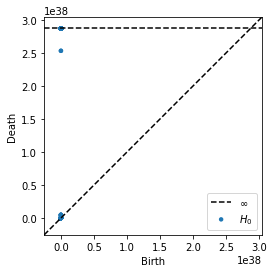

In [25]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'][0])

## Pruned LT Homology

In [26]:
# load the LT model.
model_lt = torch.load(model_loc1)

In [28]:
alnt = AlexNet()

# access model params and add to list `params`. We are ignoring bias weights for now.
params_lt = []
for name, param in model_lt.named_parameters():
    if 'weight' in name:
        pnum = param.data.cpu().numpy()
        print('Parameter Shape: ', pnum.shape)
        params_lt.append(pnum)
        
# add weights to conv and linear layer param info dict
param_info_lt = alnt.param_info
j = 0
for i in range(len(param_info_lt)):
    p = param_info_lt[i]
    if p['layer_type'] == 'Conv2d' or p['layer_type'] == 'Linear':
        p['param'] = params_lt[j]
        j += 1
    else:
        p['param'] = None

Parameter Shape:  (64, 1, 3, 3)
Parameter Shape:  (192, 64, 5, 5)
Parameter Shape:  (384, 192, 3, 3)
Parameter Shape:  (256, 384, 3, 3)
Parameter Shape:  (256, 256, 3, 3)
Parameter Shape:  (4096, 256)
Parameter Shape:  (4096, 4096)
Parameter Shape:  (10, 4096)


In [29]:
# test this model's accuracy. (not actually a LT because I'm lazy and picked too high of a threshold)
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 11.33


In [30]:
# compute networkx representation of LT NN.
G_lt = to_directed_networkx(param_info_lt, input_size)

(1, 1, 28, 28)
Layer: Conv1
Channel: 0
(1, 64, 15, 15)
Layer: MaxPool1
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
Channel: 17
Channel: 18
Channel: 19
Channel: 20
Channel: 21
Channel: 22
Channel: 23
Channel: 24
Channel: 25
Channel: 26
Channel: 27
Channel: 28
Channel: 29
Channel: 30
Channel: 31
Channel: 32
Channel: 33
Channel: 34
Channel: 35
Channel: 36
Channel: 37
Channel: 38
Channel: 39
Channel: 40
Channel: 41
Channel: 42
Channel: 43
Channel: 44
Channel: 45
Channel: 46
Channel: 47
Channel: 48
Channel: 49
Channel: 50
Channel: 51
Channel: 52
Channel: 53
Channel: 54
Channel: 55
Channel: 56
Channel: 57
Channel: 58
Channel: 59
Channel: 60
Channel: 61
Channel: 62
Channel: 63
[1, 64, 7, 7]
Layer: Conv2
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 1

Channel: 148
Channel: 149
Channel: 150
Channel: 151
Channel: 152
Channel: 153
Channel: 154
Channel: 155
Channel: 156
Channel: 157
Channel: 158
Channel: 159
Channel: 160
Channel: 161
Channel: 162
Channel: 163
Channel: 164
Channel: 165
Channel: 166
Channel: 167
Channel: 168
Channel: 169
Channel: 170
Channel: 171
Channel: 172
Channel: 173
Channel: 174
Channel: 175
Channel: 176
Channel: 177
Channel: 178
Channel: 179
Channel: 180
Channel: 181
Channel: 182
Channel: 183
Channel: 184
Channel: 185
Channel: 186
Channel: 187
Channel: 188
Channel: 189
Channel: 190
Channel: 191
Channel: 192
Channel: 193
Channel: 194
Channel: 195
Channel: 196
Channel: 197
Channel: 198
Channel: 199
Channel: 200
Channel: 201
Channel: 202
Channel: 203
Channel: 204
Channel: 205
Channel: 206
Channel: 207
Channel: 208
Channel: 209
Channel: 210
Channel: 211
Channel: 212
Channel: 213
Channel: 214
Channel: 215
Channel: 216
Channel: 217
Channel: 218
Channel: 219
Channel: 220
Channel: 221
Channel: 222
Channel: 223
Channel: 224

Channel: 233
Channel: 234
Channel: 235
Channel: 236
Channel: 237
Channel: 238
Channel: 239
Channel: 240
Channel: 241
Channel: 242
Channel: 243
Channel: 244
Channel: 245
Channel: 246
Channel: 247
Channel: 248
Channel: 249
Channel: 250
Channel: 251
Channel: 252
Channel: 253
Channel: 254
Channel: 255
[1, 256, 1, 1]
Layer: Linear1
[1, 256, 1, 1]
Layer: Linear2
Layer: Linear3


In [31]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
rips_lt = ripser(nx.to_scipy_sparse_matrix(G_lt), distance_matrix=True, maxdim=1)
rips_lt

{'dgms': [array([[0.        , 9.59934807],
         [0.        , 9.71740818],
         [0.        , 9.93188667],
         ...,
         [0.        ,        inf],
         [0.        ,        inf],
         [0.        ,        inf]]),
  array([[2.30469638e+32,            inf],
         [7.77415368e+31,            inf],
         [6.06496033e+31,            inf],
         ...,
         [1.66235123e+01,            inf],
         [1.64302101e+01,            inf],
         [1.60450382e+01,            inf]])],
 'cocycles': [[], []],
 'num_edges': 1573369,
 'dperm2all': <34307x34307 sparse matrix of type '<class 'numpy.float64'>'
 	with 2527055 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 34304, 34305, 34306]),
 'r_cover': 0.0}

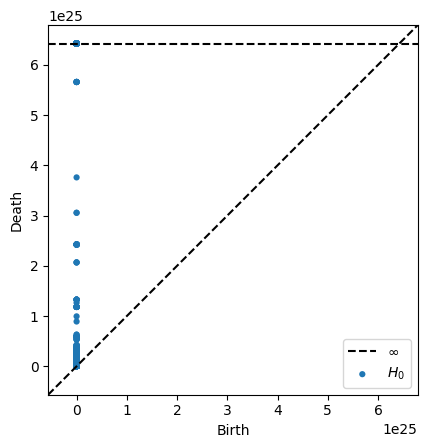

In [32]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'][0])